In [4]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from scipy import stats



#Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA



#importing machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
import pickle



#Secondary imports
import pandas_profiling as pp
from scipy.stats import pearsonr
import pickle


%matplotlib inline

np.set_printoptions(precision=2, suppress=True)

## Reading Datasets

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

cols = np.load('final_col.npy').tolist()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
len(cols)

234

In [7]:
remove = []

for i in range(len(cols)):
    value = (1 - train[train[cols[i]]!=0].shape[0]/train.shape[0]) * 100
    if value > 60:
        remove.append(cols[i])


for i in range(len(remove)):
    cols.remove(remove[i])

### Finding missing values, and selecting  columns with less than 5% missing values

In [8]:
seta = cols.copy()

In [9]:
percent_missing = train[seta].isnull().sum() * 100 / len(train[seta])
missing_value_df = pd.DataFrame({'column_name': train[seta].columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.reset_index(inplace=True, drop=True)

In [10]:
mis_col = missing_value_df[missing_value_df['percent_missing']<5].sort_values('percent_missing', ascending=False).column_name.values.tolist()

In [11]:
len(cols)

167

In [12]:
len(mis_col)

167

In [13]:
rf = RandomForestClassifier()


#Creating features from training dataset
features1 = train[mis_col]


targets = train['Col2']

rf.fit(features1, targets) 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = mis_col,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


         importance
Col10          0.03
Col11          0.03
Col26          0.02
Col196         0.02
Col25          0.02
Col205         0.02
Col186         0.02
Col168         0.02
Col182         0.02
Col202         0.02
Col591         0.02
Col198         0.02
Col188         0.01
Col189         0.01
Col120         0.01
Col49          0.01
Col68          0.01
Col75          0.01
Col47          0.01
Col52          0.01
Col44          0.01
Col51          0.01
Col1008        0.01
Col1024        0.01
Col1014        0.01
Col1015        0.01
Col1686        0.01
Col1212        0.01
Col76          0.01
Col1000        0.01
...             ...
Col1589        0.00
Col1034        0.00
Col1167        0.00
Col1319        0.00
Col63          0.00
Col1239        0.00
Col61          0.00
Col1035        0.00
Col62          0.00
Col64          0.00
Col1218        0.00
Col1259        0.00
Col1001        0.00
Col1265        0.00
Col1143        0.00
Col1631        0.00
Col1048        0.00
Col1215        0.00


In [14]:
threshold = 0.001

In [15]:
thres_col = sorted(feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist(), key = lambda x: int(x[3:]))
print(len(thres_col))

167


In [16]:
thres_col.remove('Col32')

thres_col.remove('Col33')

In [17]:
thres_col.append('Col3')

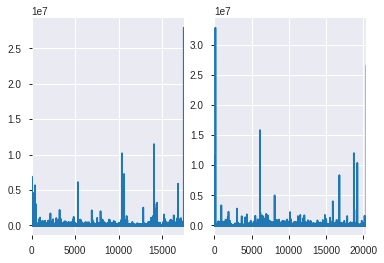

In [18]:
fig, axs = plt.subplots(1,2)

train['Col10'].plot(ax=axs[0])
test['Col10'].plot(ax=axs[1])

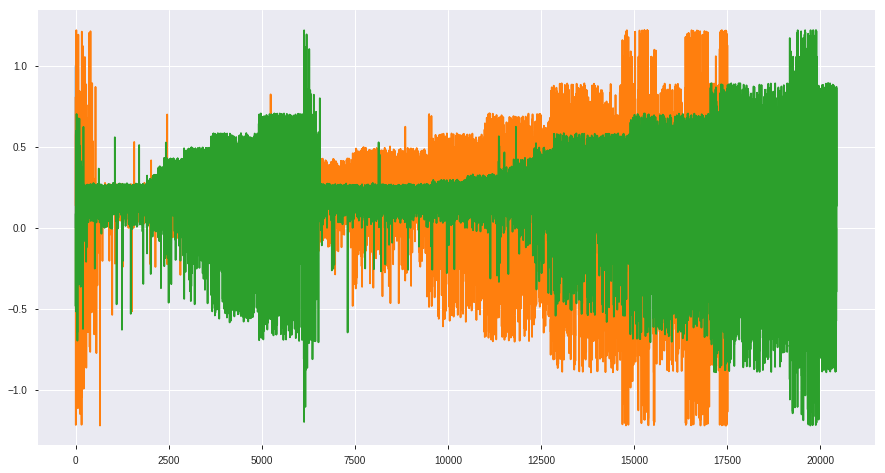

In [19]:
plt.figure(figsize=(15, 8))
plt.step(train['Col2'], train['Col2'])
plt.plot(train['Col25'])
plt.plot(test['Col25'])


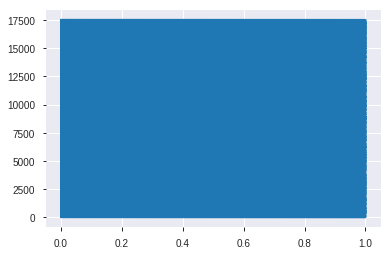

In [20]:
plt.plot(train['Col2'], range(len(train)))

Col10


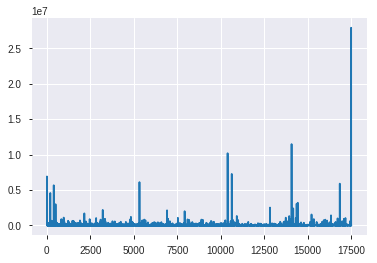

Col11


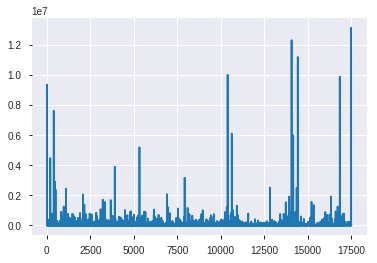

Col25


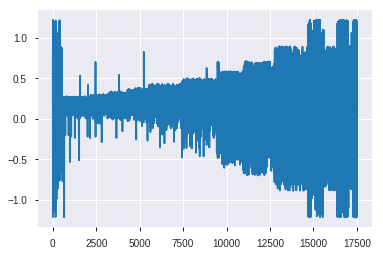

Col26


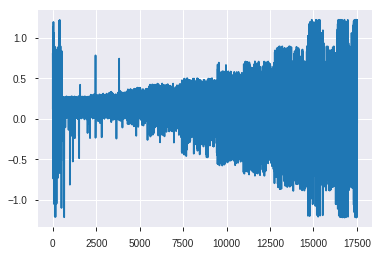

Col168


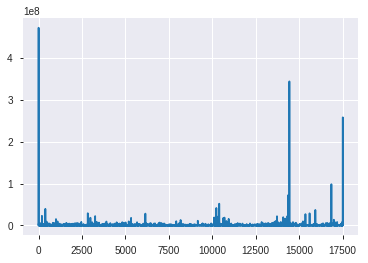

Col182


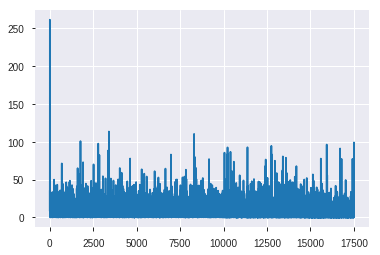

Col186


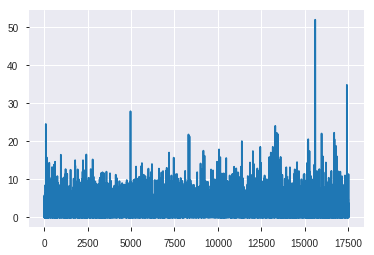

Col188


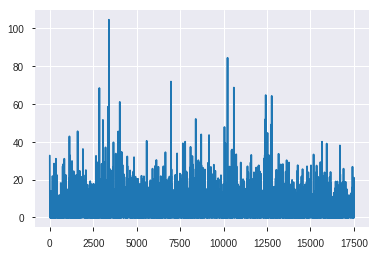

Col189


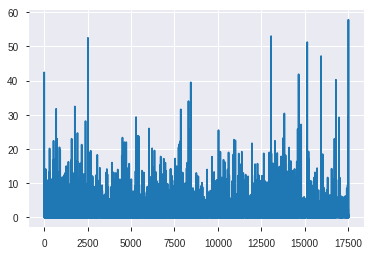

Col196


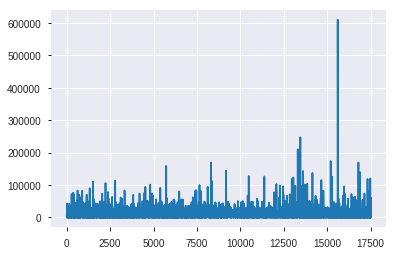

Col198


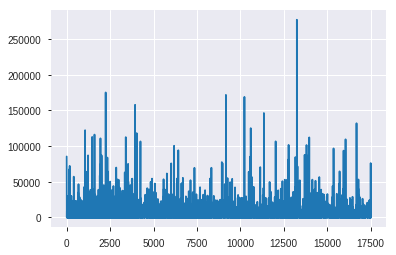

Col202


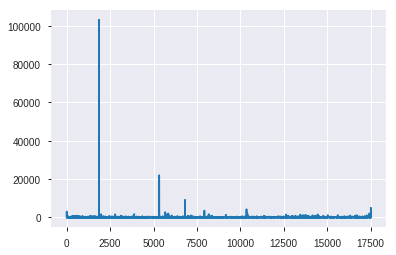

Col205


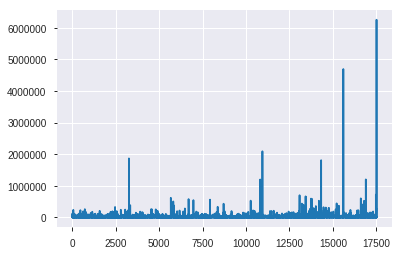

Col591


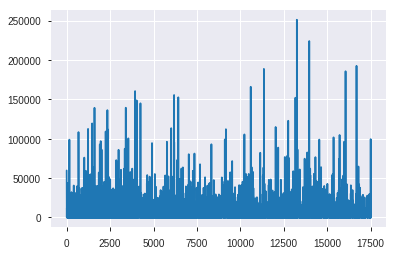

Col3


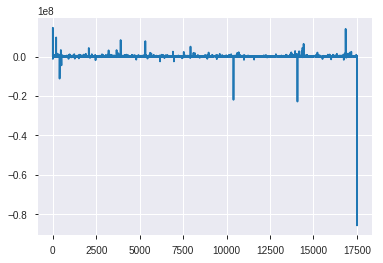

In [21]:
for i in thres_col:
    if train[i].nunique() >= 11:
        print(i)
        plt.plot(train[i])
        plt.show()
#         train[i] = train[i].ewm(span = 20).mean()
#         test[i] = test[i].ewm(span = 20).mean()

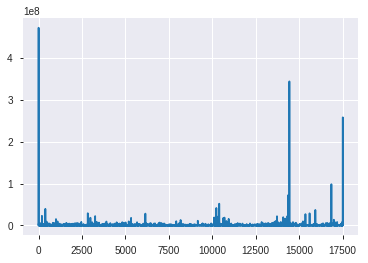

In [22]:
plt.plot(train['Col168'])

In [23]:
train_data = train[thres_col].values
train_target = train['Col2'].values

In [24]:
# from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss
# sm = SMOTE(random_state = 2) 
sm = NearMiss(random_state = 2) 

sm_train_data, sm_train_target = sm.fit_sample(train_data, train_target) 

In [25]:
sm_train_data.shape

(3522, 166)

## For lightgbm with smote

In [26]:
lgbb = lgb.LGBMClassifier()
# lgbb = CatBoostClassifier(verbose=False)

# ctb = CatBoostClassifier(depth = 1, verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(sm_train_data, sm_train_target):
    print("hello", count)
    count+=1
   
    trainx, testx = sm_train_data[train_index], sm_train_data[test_index]
    trainy, testy = sm_train_target[train_index], sm_train_target[test_index]
    
    
    lgbb.fit(trainx, trainy)
    result = lgbb.predict_proba(testx)
    
    re_result = []

    for i in range(len(result)):
        if result[i][1] > 0.5:
            re_result.append(1)
        else:
            re_result.append(0)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(re_result, testy)
#     ctb.fit(trainx, trainy)
#     avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)

hello 0
hello 1
hello 2
hello 3
hello 4
Average accuracy was:  0.8588913211434457


## For lightgbm

In [27]:
lgbb.fit(sm_train_data, sm_train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
result = lgbb.predict_proba(test[thres_col])

In [81]:
re_result = []

for i in range(len(result)):
    if result[i][1] > 0.999974:
        re_result.append(1)
    else:
        re_result.append(0)

In [82]:
result.shape

(20442, 2)

In [83]:
np.unique(re_result, return_counts=True)

(array([0, 1]), array([20362,    80]))

In [84]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = re_result

In [85]:
submission.to_csv('submission.csv', index=False)

In [95]:
train['Col2'].values

array([1, 0, 0, ..., 0, 0, 0])

In [96]:
import seaborn as sns

In [ ]:
grid = sns.lmplot('x', 'y', data, size=7, truncate=True, scatter_kws={"s": 100})

KeyboardInterrupt: 

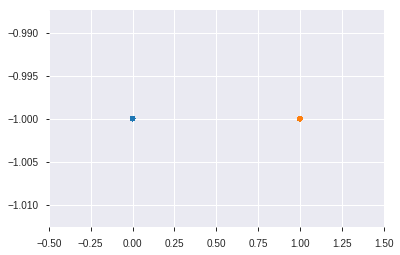

In [100]:
sns.swarmplot(train['Col2'].values, [-1 for _ in range(len(train))])

Col10


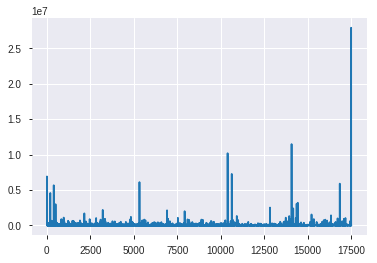

Col11


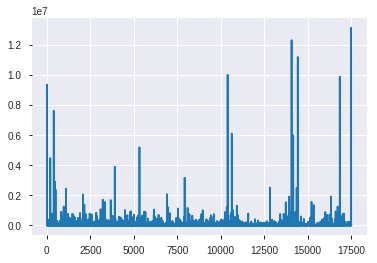

Col25


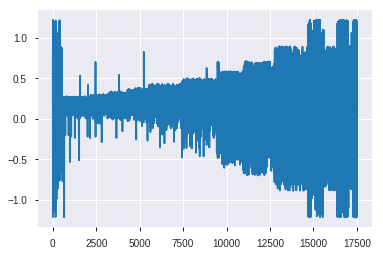

Col26


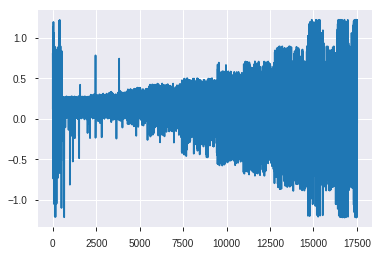

Col29


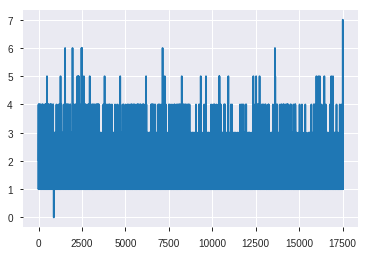

Col34


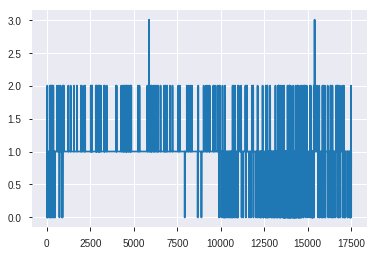

Col36


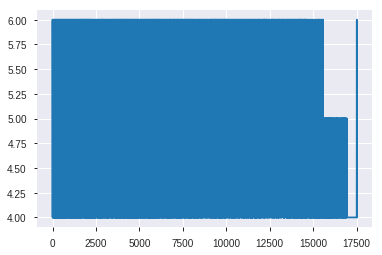

Col44


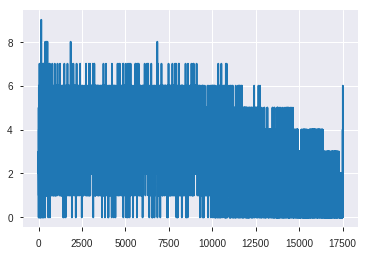

Col45


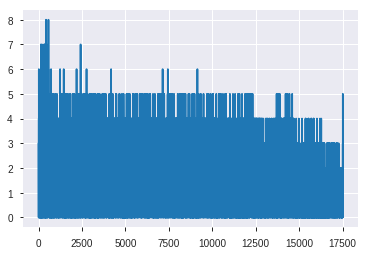

Col47


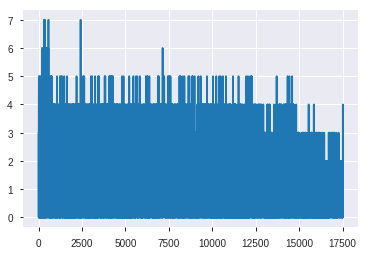

Col49


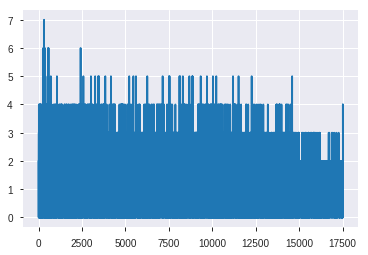

Col50


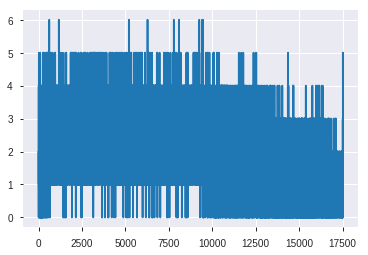

Col51


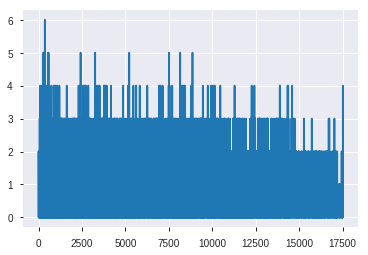

Col52


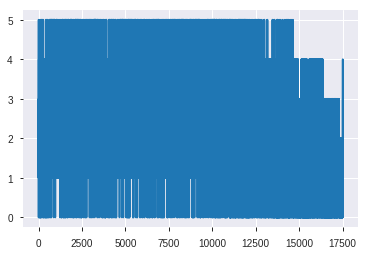

Col54


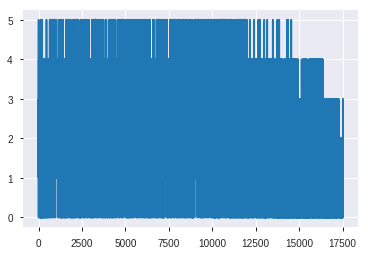

Col58


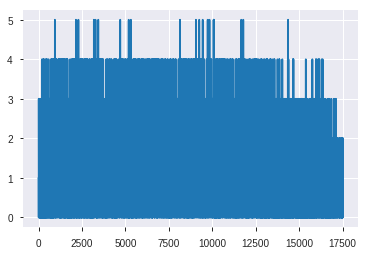

Col60


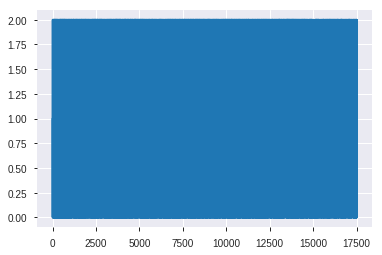

Col61


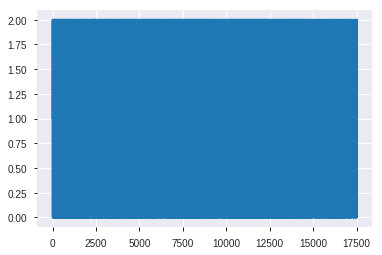

Col62


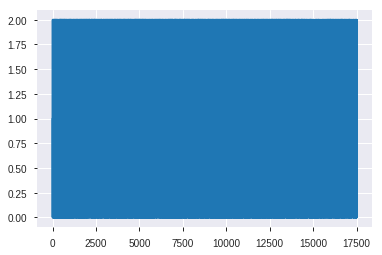

Col63


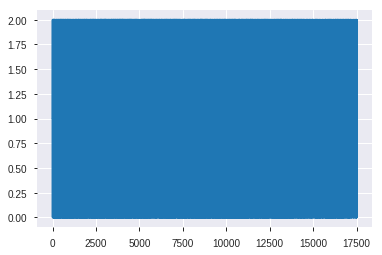

Col64


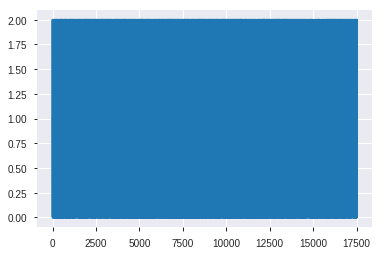

Col65


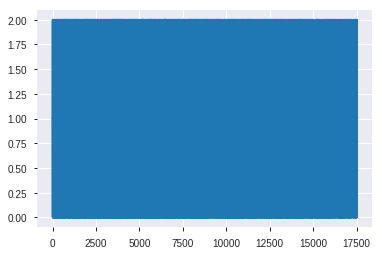

Col66


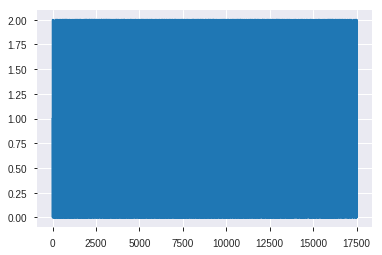

Col68


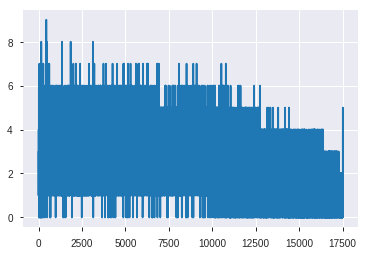

Col69


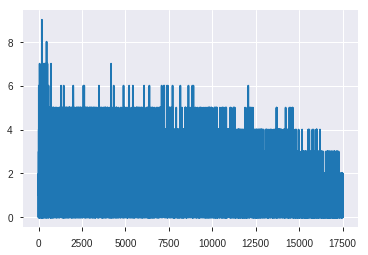

Col71


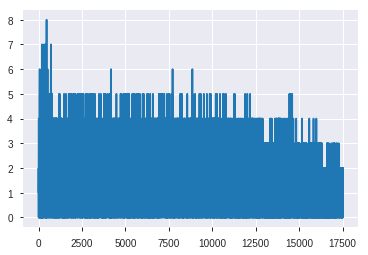

Col73


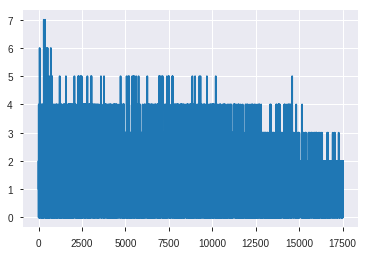

Col74


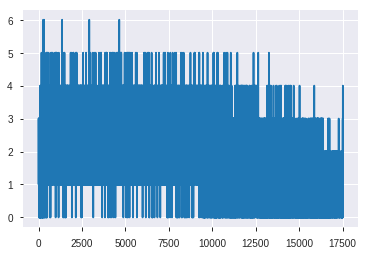

Col75


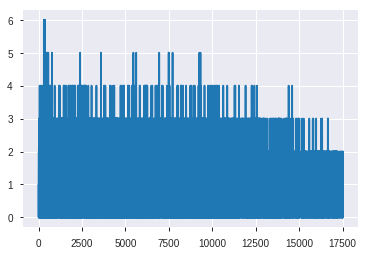

Col76


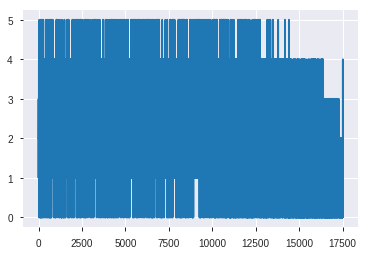

Col78


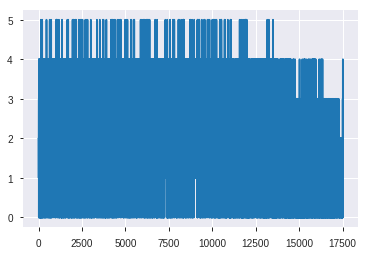

Col80


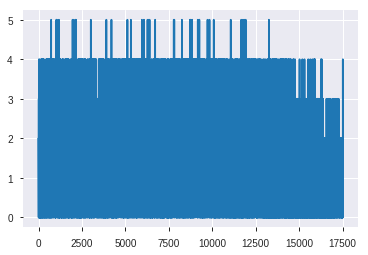

Col82


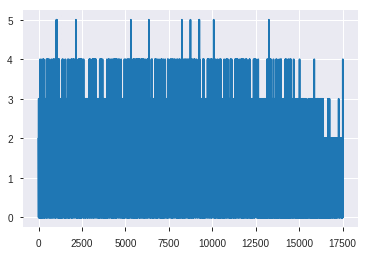

Col84


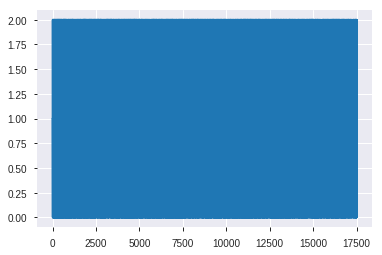

Col85


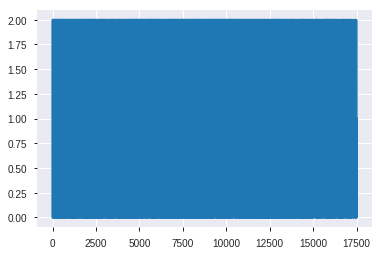

Col86


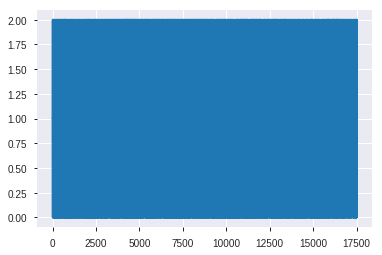

Col87


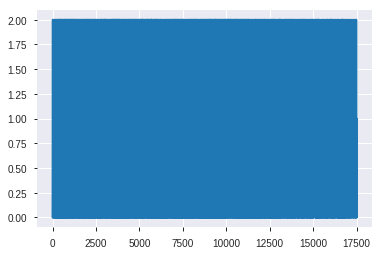

Col88


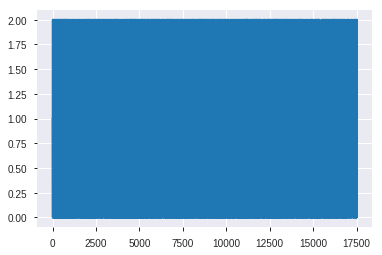

Col89


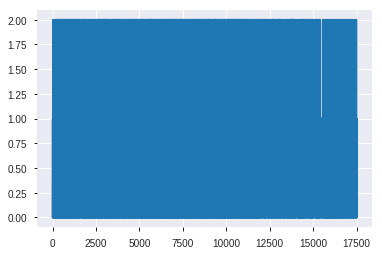

Col90


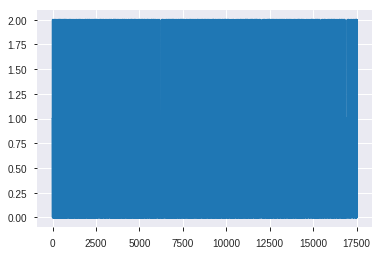

Col120


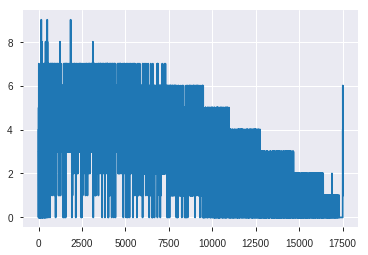

Col121


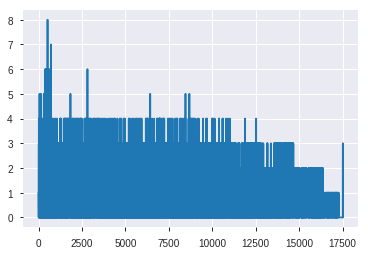

Col123


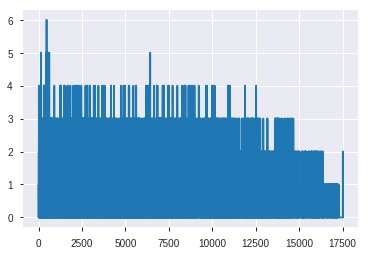

Col168


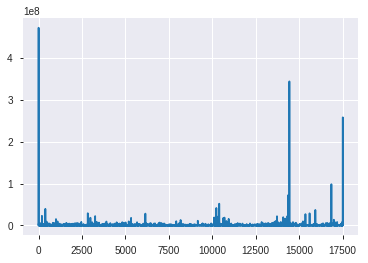

Col182


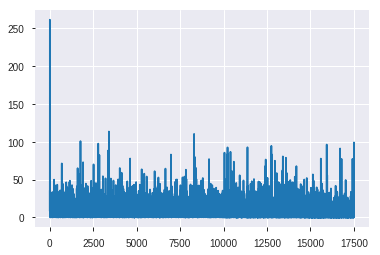

Col186


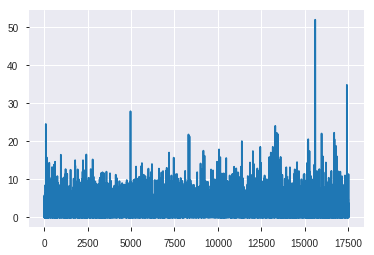

Col188


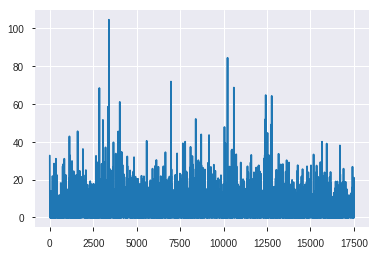

Col189


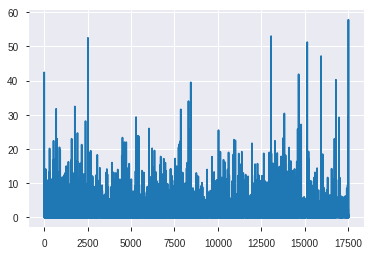

Col196


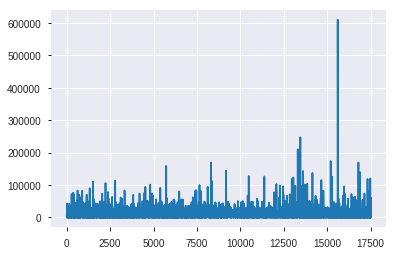

Col198


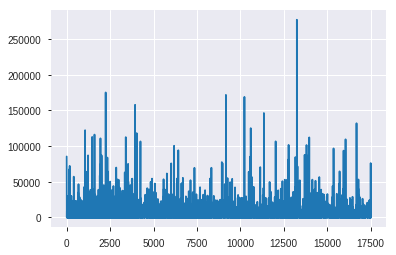

Col202


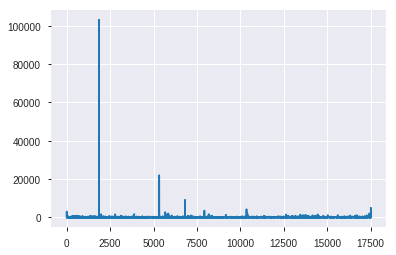

Col205


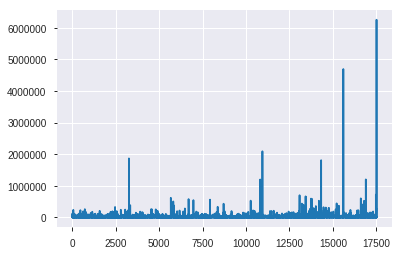

Col591


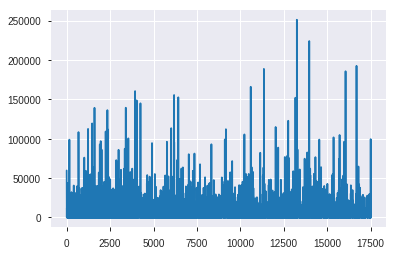

Col1000


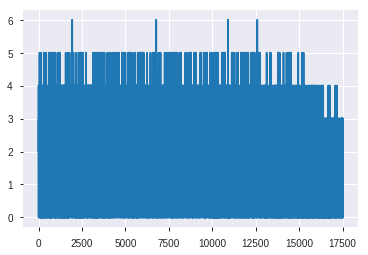

Col1001


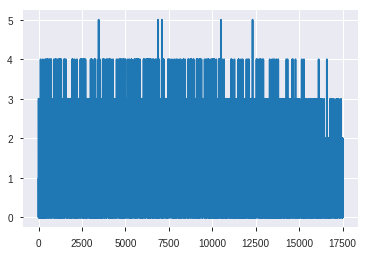

Col1002


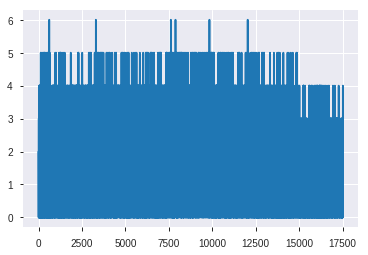

Col1003


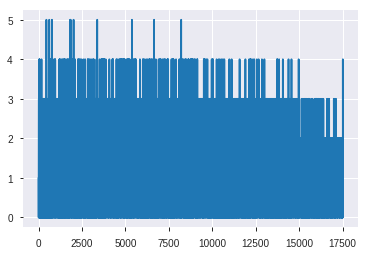

Col1006


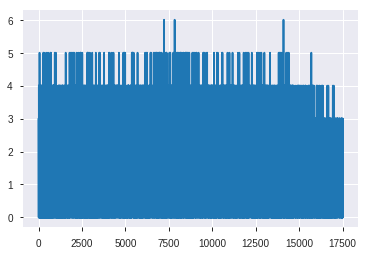

Col1007


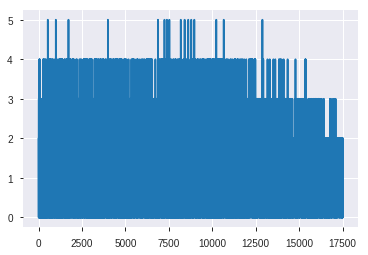

Col1008


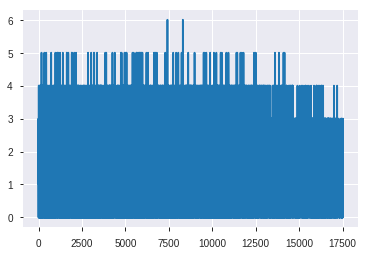

Col1009


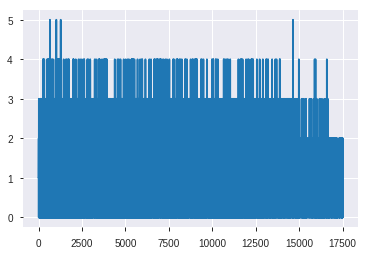

Col1014


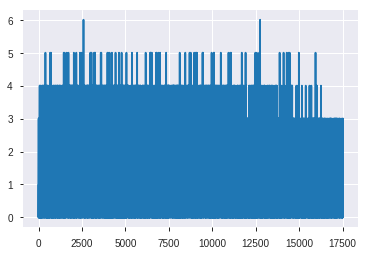

Col1015


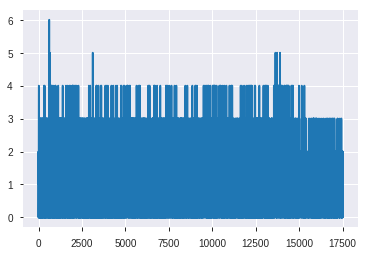

Col1020


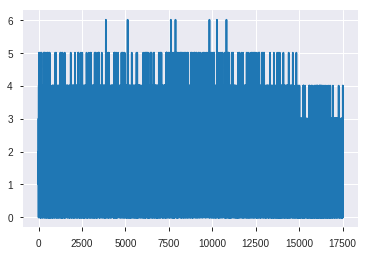

Col1021


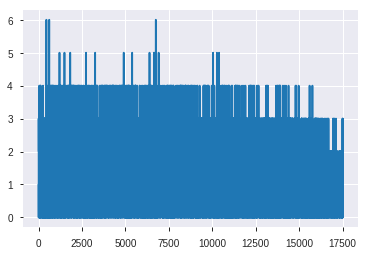

Col1024


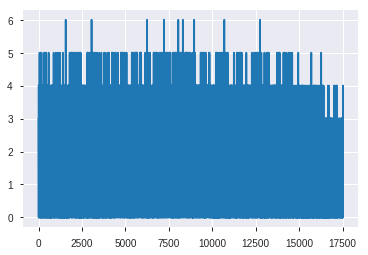

Col1025


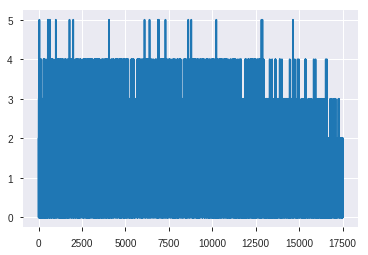

Col1026


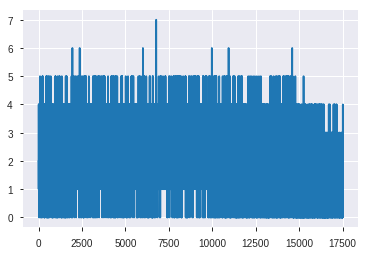

Col1027


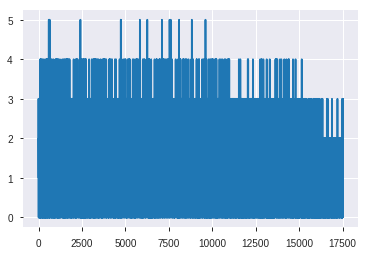

Col1028


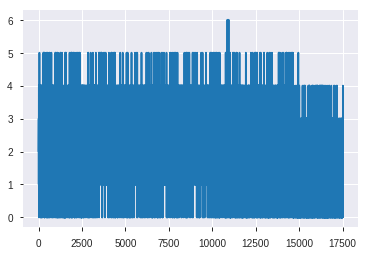

Col1029


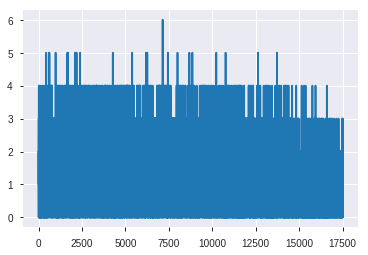

Col1030


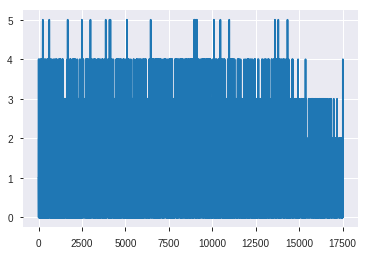

Col1031


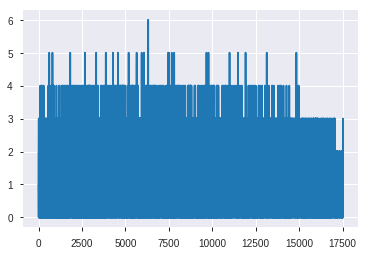

Col1034


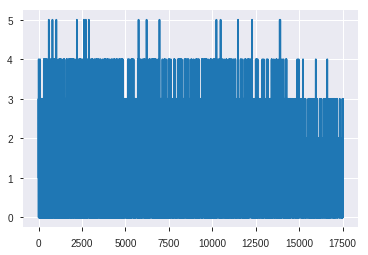

Col1035


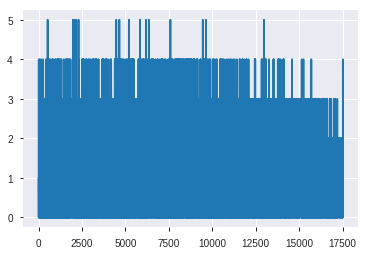

Col1036


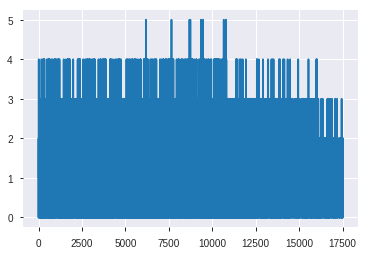

Col1037


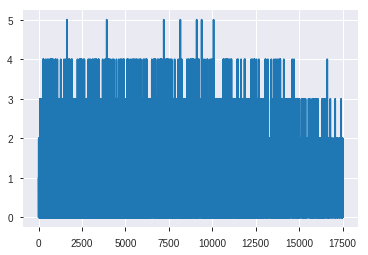

Col1044


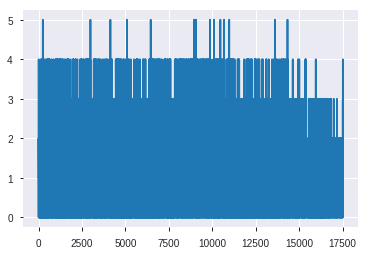

Col1045


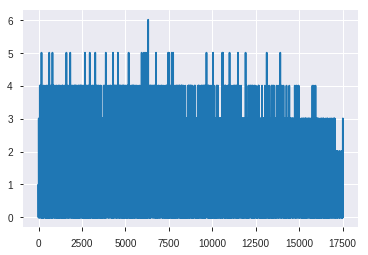

Col1048


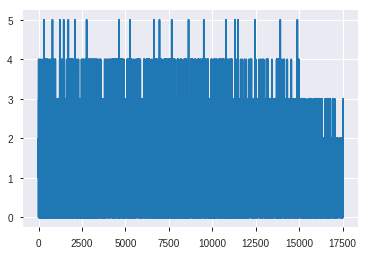

Col1049


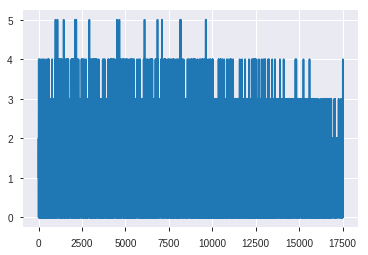

Col1050


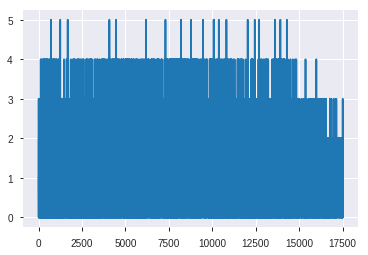

Col1051


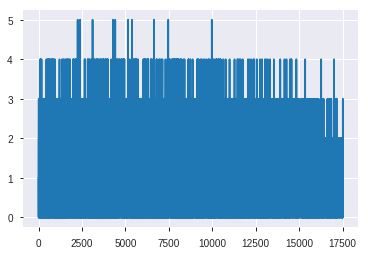

Col1054


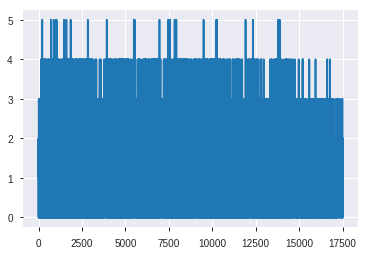

Col1055


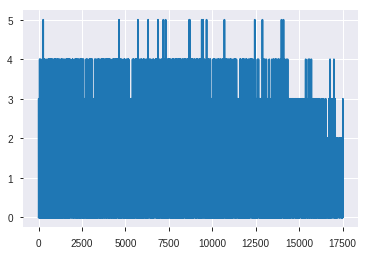

Col1056


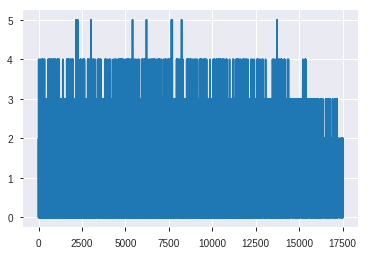

Col1057


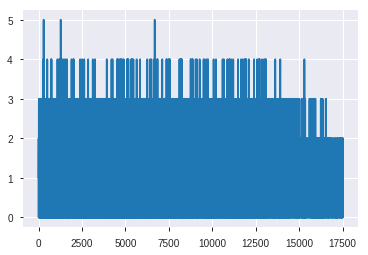

Col1062


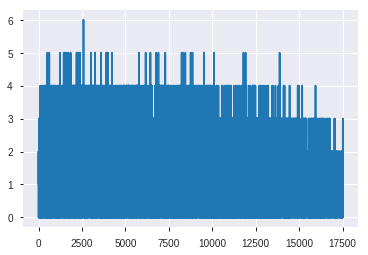

Col1063


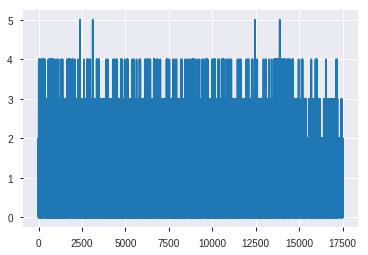

Col1068


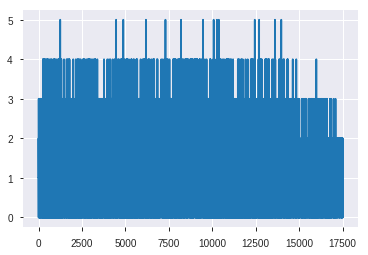

Col1069


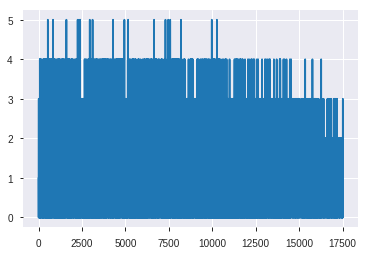

Col1072


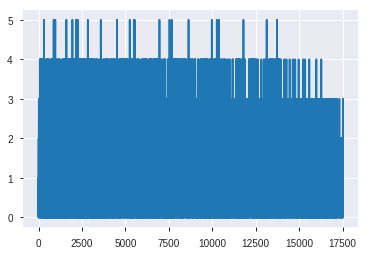

Col1073


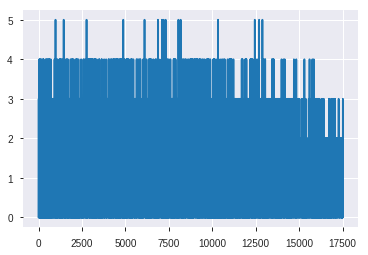

Col1074


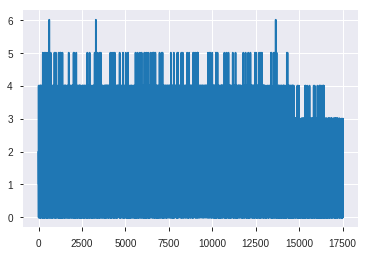

Col1075


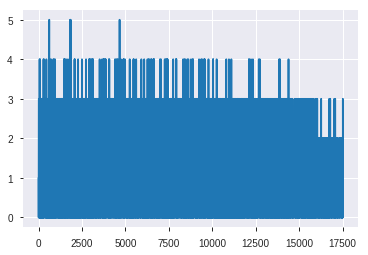

Col1078


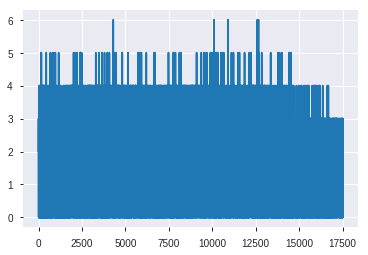

Col1079


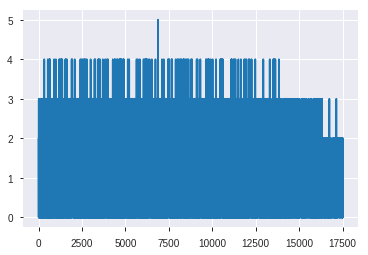

Col1081


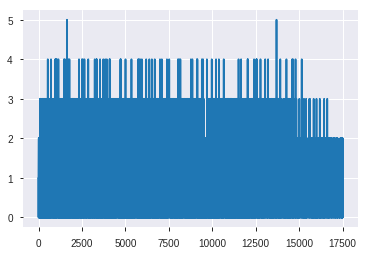

Col1089


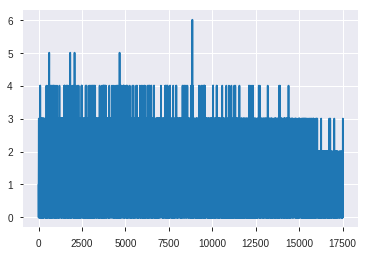

Col1118


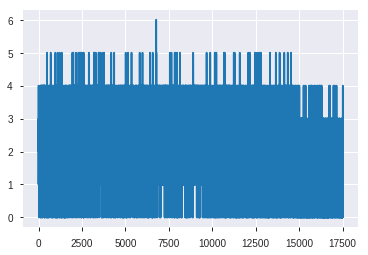

Col1119


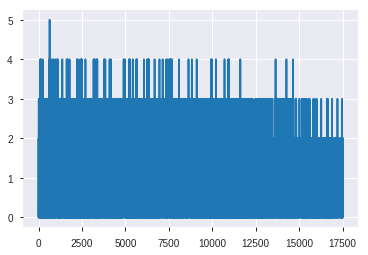

Col1121


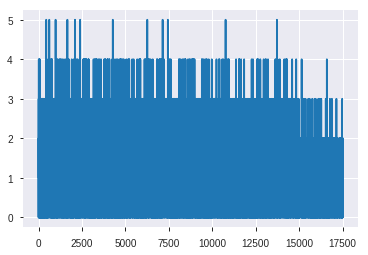

Col1123


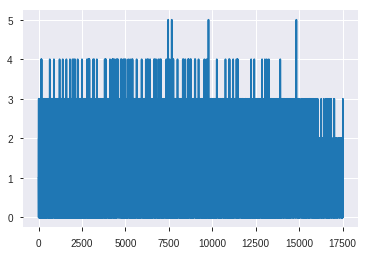

Col1127


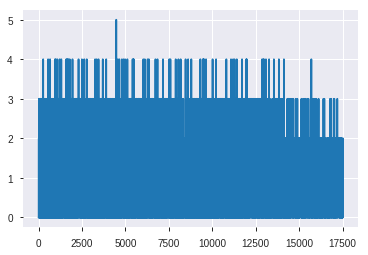

Col1137


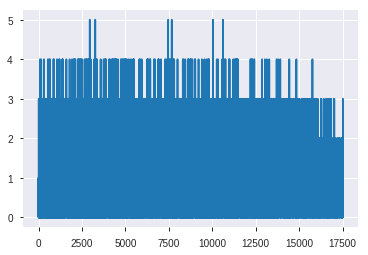

Col1140


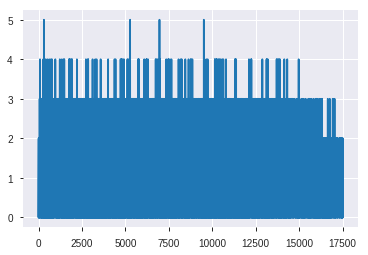

Col1141


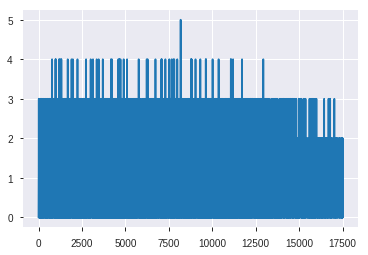

Col1143


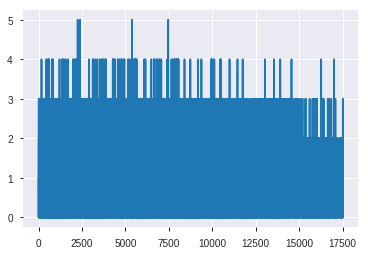

Col1161


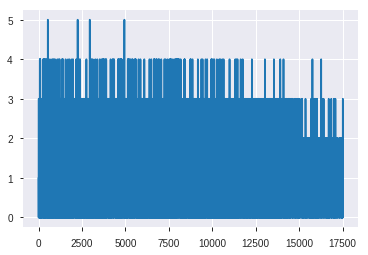

Col1165


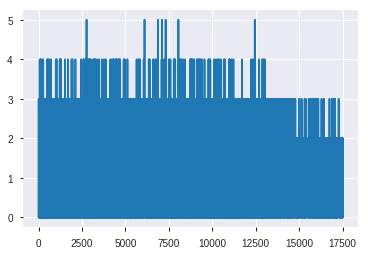

Col1167


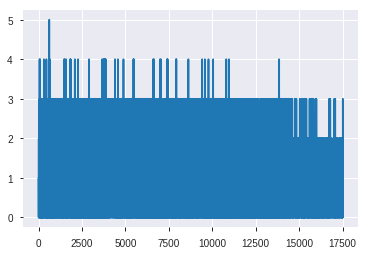

Col1181


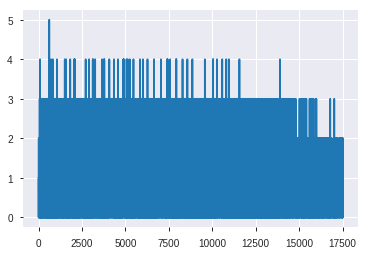

Col1185


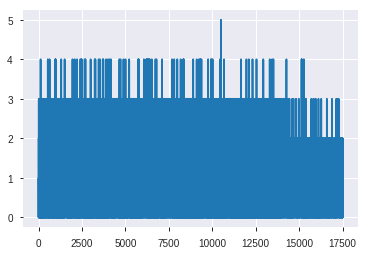

Col1205


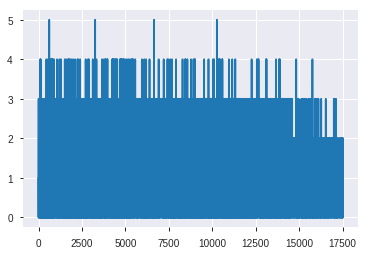

Col1210


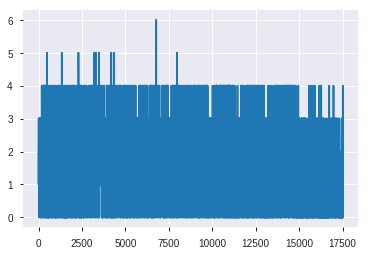

Col1211


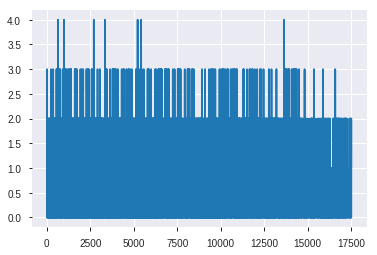

Col1212


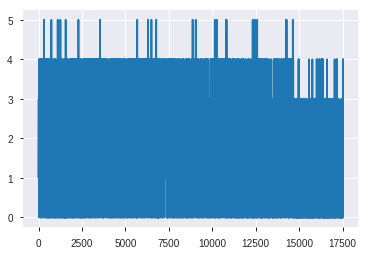

Col1213


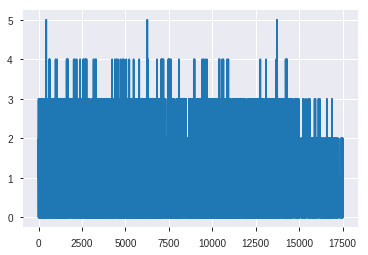

Col1214


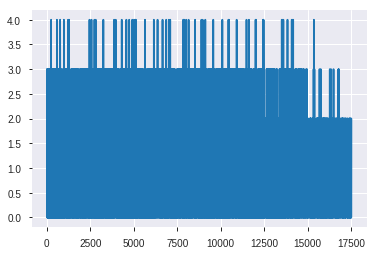

Col1215


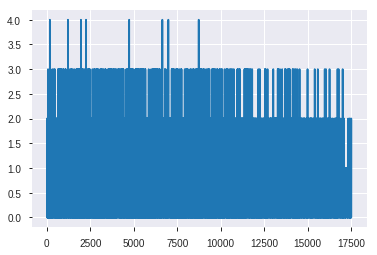

Col1218


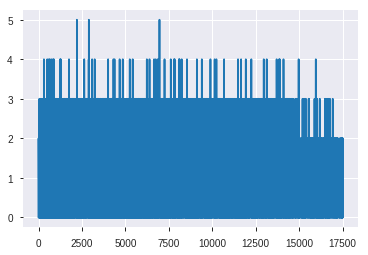

Col1219


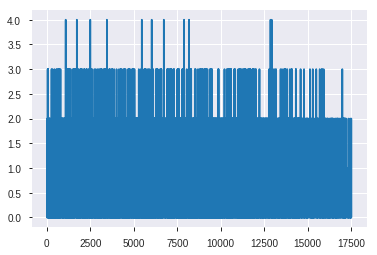

Col1221


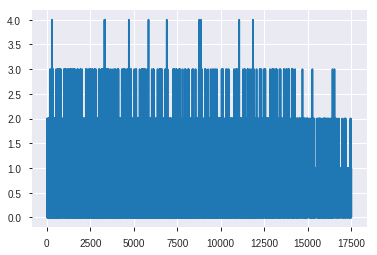

Col1228


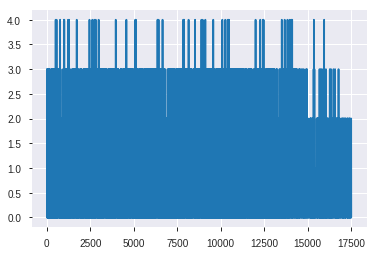

Col1229


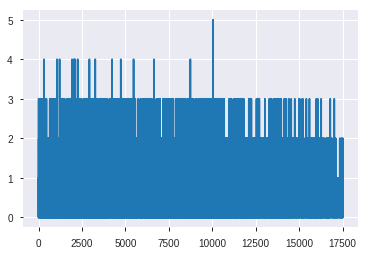

Col1231


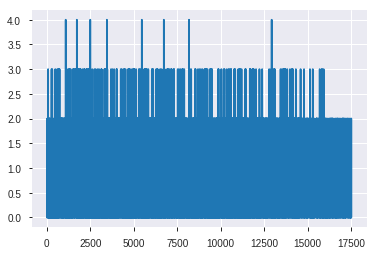

Col1232


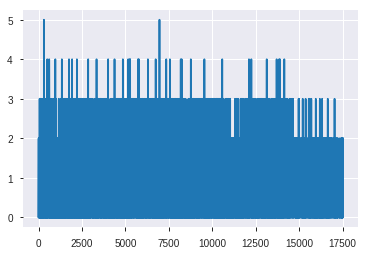

Col1235


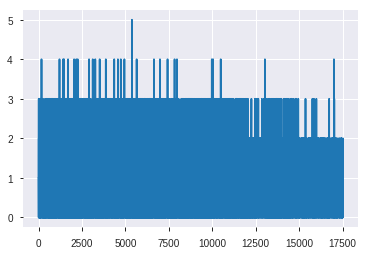

Col1239


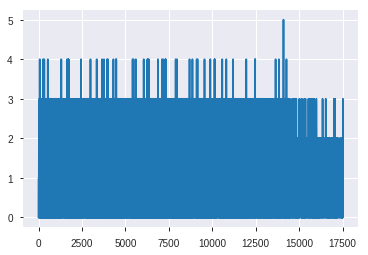

Col1241


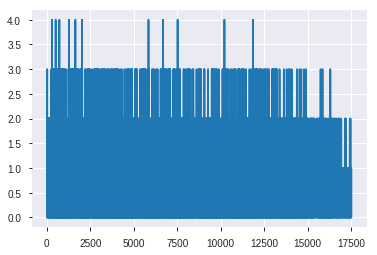

Col1253


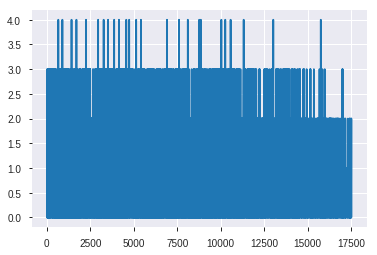

Col1257


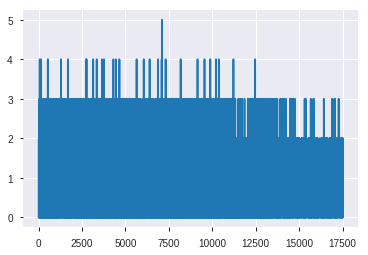

Col1259


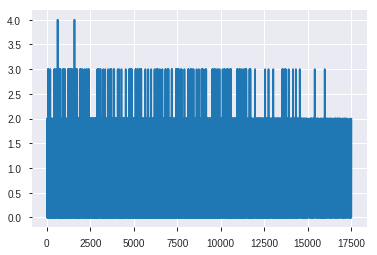

Col1263


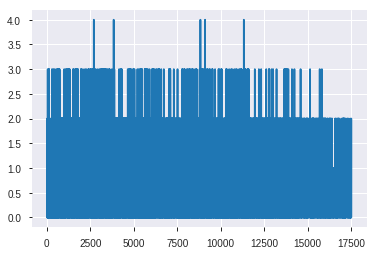

Col1265


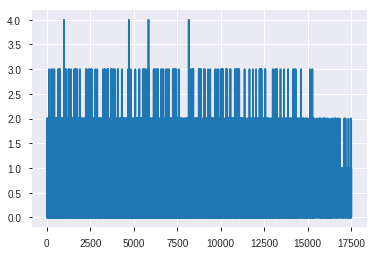

Col1272


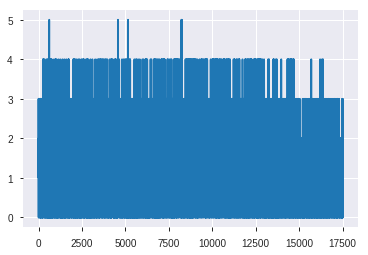

Col1273


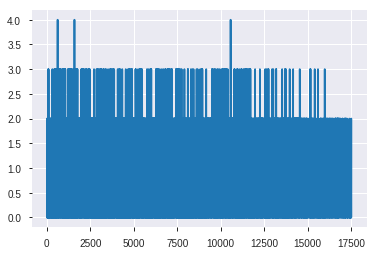

Col1277


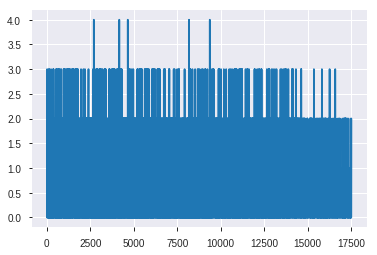

Col1279


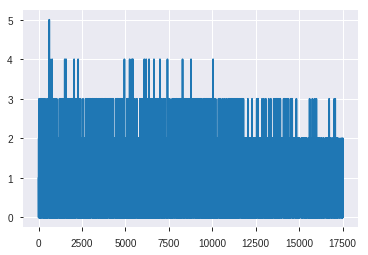

Col1283


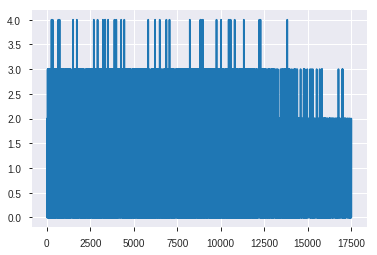

Col1285


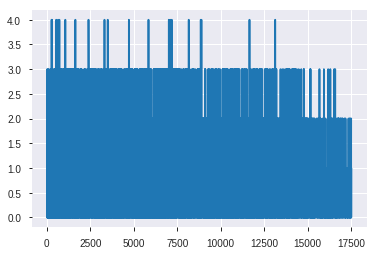

Col1297


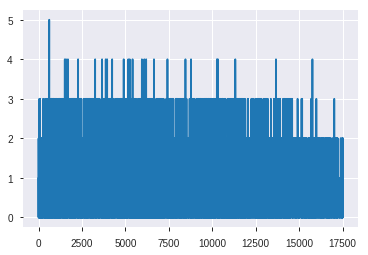

Col1301


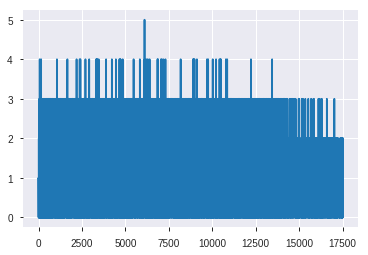

Col1304


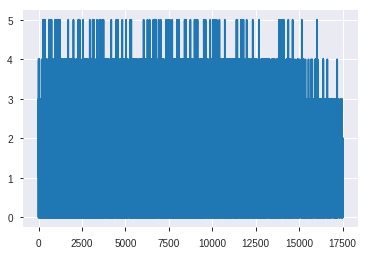

Col1305


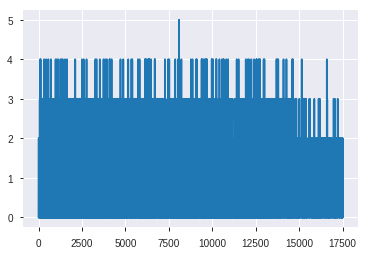

Col1319


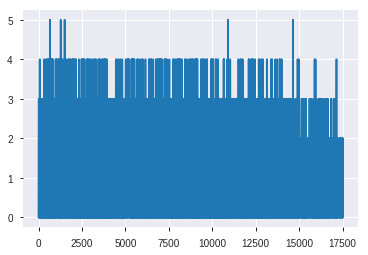

Col1346


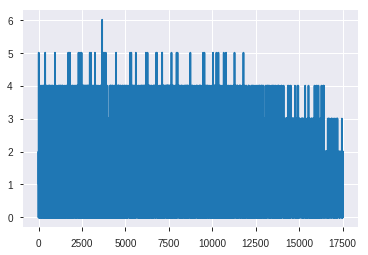

Col1347


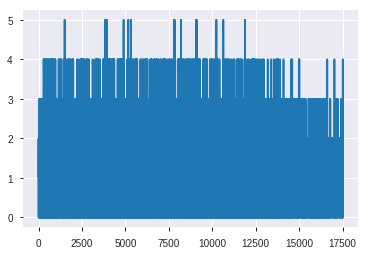

Col1360


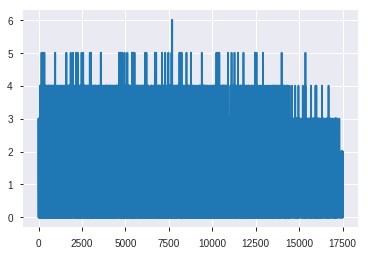

Col1361


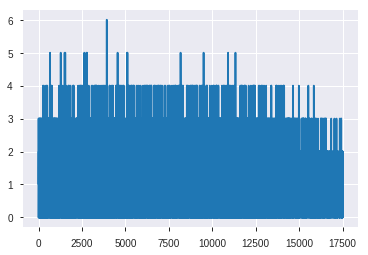

Col1388


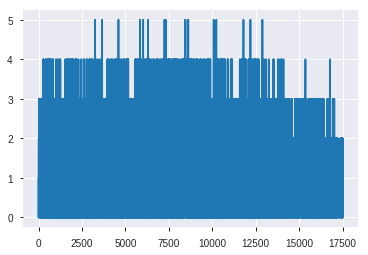

Col1389


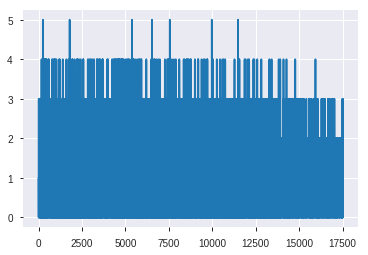

Col1527


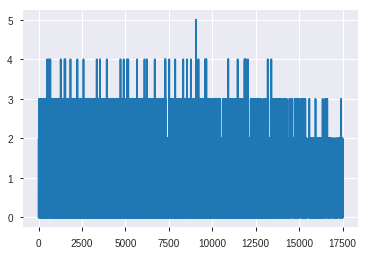

Col1589


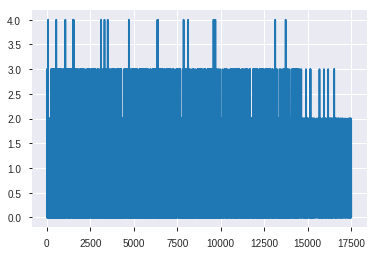

Col1631


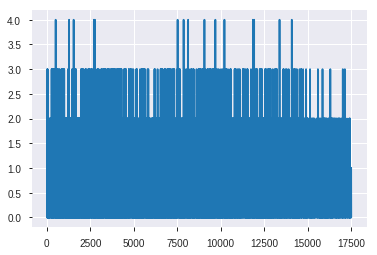

Col1666


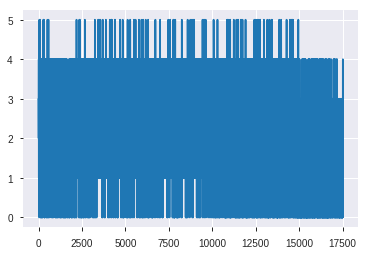

Col1667


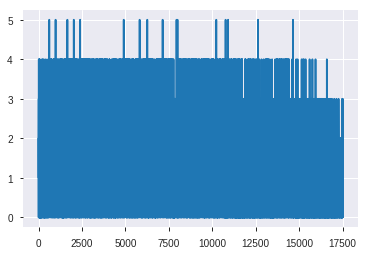

Col1686


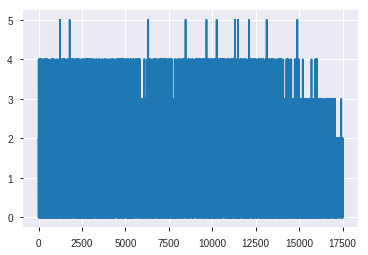

Col1687


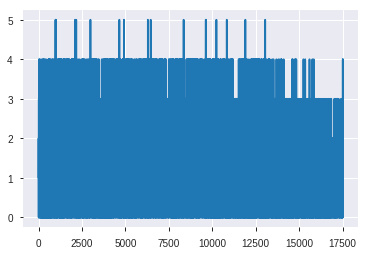

Col1688


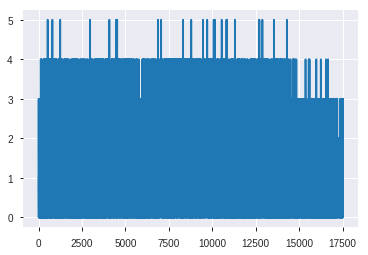

Col1689


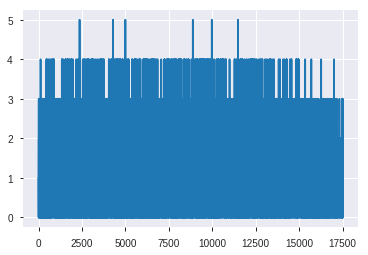

Col1706


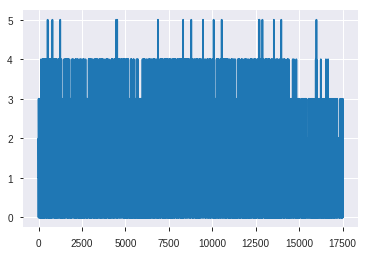

Col1707


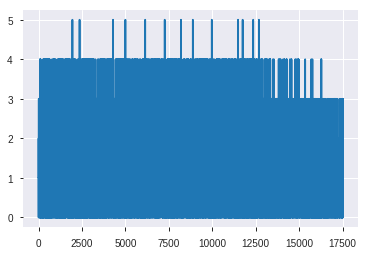

Col1710


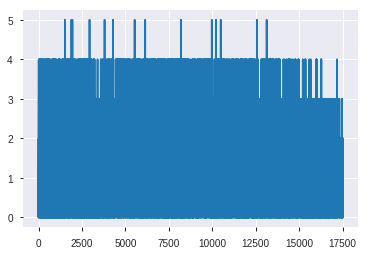

Col1711


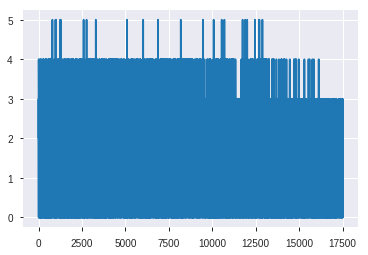

Col3


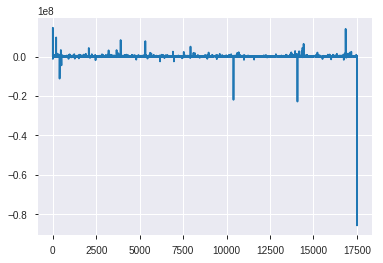

In [86]:
for i in thres_col:
    print(i)
    plt.plot(train[i])    
    plt.show()

In [118]:
np.unique(re_result, return_counts=True)

(array([0, 1]), array([20139,   303]))

In [112]:
train_data.shape

(17521, 166)